<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%EC%98%88%EC%A0%9C%2Bh2o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install h2o
!pip install mxnet
!pip install xlsxwriter

In [27]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

# 1. 기상 데이터 불러오기

In [28]:
weather_path = '/content/AWS 삼척 시간단위 기상데이터'
weather_list = []

for file in os.listdir(weather_path):
    weather_list.append(pd.read_csv(weather_path + '/' + file, encoding='cp949'))

weather = pd.concat(weather_list)
weather.index = pd.to_datetime(weather['일시'])
weather = weather.drop(columns=['지점', '지점명', '풍향(deg)', '일시', '현지기압(hPa)', '해면기압(hPa)'])
weather = weather.sort_index()
weather

,기온(°C),풍속(m/s),강수량(mm),습도(%)
일시,,,,
2020-01-01 00:00:00,-3.2,2.5,0.0,19.3
2020-01-01 01:00:00,-3.0,2.3,0.0,19.9
2020-01-01 02:00:00,-2.3,2.7,0.0,27.0
2020-01-01 03:00:00,-1.8,2.9,0.0,35.1
2020-01-01 04:00:00,-1.5,3.2,0.0,40.2
...,...,...,...,...
2023-03-31 19:00:00,13.5,0.9,0.0,76.0
2023-03-31 20:00:00,12.7,0.2,0.0,77.0
2023-03-31 21:00:00,11.5,0.1,0.0,80.0


# 2. 미세먼지 데이터 불러오기

In [29]:
dust = pd.read_csv('미세먼지 데이터.csv', encoding='cp949')
dust.index = pd.to_datetime(dust['일시'])
dust = dust.drop(columns=['일시'])
dust

,PM10,PM2.5
일시,,
2020-01-01 00:00:00,17.5,8.0
2020-01-01 01:00:00,17.0,7.5
2020-01-01 02:00:00,16.5,8.5
2020-01-01 03:00:00,14.5,7.5
2020-01-01 04:00:00,14.5,8.5
...,...,...
2023-03-31 19:00:00,68.5,27.0
2023-03-31 20:00:00,64.5,30.5
2023-03-31 21:00:00,70.0,30.5


# 3. 태양광 발전량 데이터 불러오기

In [30]:
# solar = pd.read_csv('./DATA/태양광 발전량 데이터.csv')
solar = pd.read_csv('태양광 발전량 데이터.csv')
solar.index = pd.to_datetime(solar['일시'])
solar = solar.drop(columns=['일시'])
solar

,AC_출력_1,AC_출력_2
일시,,
2020-01-01 00:00:00,NaN,NaN
2020-01-01 01:00:00,NaN,NaN
2020-01-01 02:00:00,NaN,NaN
2020-01-01 03:00:00,NaN,NaN
2020-01-01 04:00:00,NaN,NaN
...,...,...
2023-03-31 19:00:00,NaN,NaN
2023-03-31 20:00:00,NaN,NaN
2023-03-31 21:00:00,NaN,NaN


# 4. 세 개 데이터 병합

In [31]:
from functools import reduce
result = reduce(lambda x,y: pd.merge(x,y, on='일시', how='outer'), [solar, weather, dust])
result

,AC_출력_1,AC_출력_2,기온(°C),풍속(m/s),강수량(mm),습도(%),PM10,PM2.5
일시,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,-3.2,2.5,0.0,19.3,17.5,8.0
2020-01-01 01:00:00,NaN,NaN,-3.0,2.3,0.0,19.9,17.0,7.5
2020-01-01 02:00:00,NaN,NaN,-2.3,2.7,0.0,27.0,16.5,8.5
2020-01-01 03:00:00,NaN,NaN,-1.8,2.9,0.0,35.1,14.5,7.5
2020-01-01 04:00:00,NaN,NaN,-1.5,3.2,0.0,40.2,14.5,8.5
...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,NaN,NaN,13.5,0.9,0.0,76.0,68.5,27.0
2023-03-31 20:00:00,NaN,NaN,12.7,0.2,0.0,77.0,64.5,30.5
2023-03-31 21:00:00,NaN,NaN,11.5,0.1,0.0,80.0,70.0,30.5


# 4. 데이터 전처리

---



In [32]:
raw_data = result.copy()

# 발전소 데이터의 결측치를 0으로 채우기
raw_data[['AC_출력_1', 'AC_출력_2']] = raw_data[['AC_출력_1', 'AC_출력_2']].fillna(0)

# columns 이름 변경
raw_data.rename(columns={'기온(°C)': 'temperature', '풍속(m/s)': 'windspeed', '강수량(mm)':'Precipitation', '습도(%)':'Humidity'}, inplace=True)

# 나머지 열 선형보간법으로 결측치 채우기
for i in raw_data.columns[2:6]: # ['temperature', 'windspeed', 'Precipitation', 'Humidity']
    raw_data[i] = raw_data[i].interpolate(method='linear', limit_direction='forward')

#결측치 확인
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28464 entries, 2020-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AC_출력_1        28464 non-null  float64
 1   AC_출력_2        28464 non-null  float64
 2   temperature    28464 non-null  float64
 3   windspeed      28464 non-null  float64
 4   Precipitation  28464 non-null  float64
 5   Humidity       28464 non-null  float64
 6   PM10           28464 non-null  float64
 7   PM2.5          28464 non-null  float64
dtypes: float64(8)
memory usage: 2.0 MB


# 5. 모델 학습을 위한 데이터셋 설정

In [33]:
# 예측 결과를 저장할 딕셔너리 선언
y_pred_tr_dict = {}
y_pred_te_dict = {}

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 37 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_scgmq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.629 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
      temperature  windspeed  Precipitation  Humidity      PM10     PM2.5
0        0.327122   0.326316            0.0  0.417559  0.070707  0.070848
1        0.287785   0.115789            0.0  0.492505  0.069264  0.078978
2        0.310559   0.147368            0.0  0.449679  0.076479  0.089431
3        0.291925   0.147368            0.0  0.481799  0.078644  0.084785
4        0.289855   0.073684            0.0  0.503212  0.086580  0.096400
...           ...        ...            ...       ...       ...       ...
2155     0.552795   0.094737            0.0  0.760171  0.097403  0.062718
2156     0.536232   0.021053            0.0  0.770878  0.091631  0.070848
2157     0.511387   0.010526            0.0  0.802998  0.099567  0.070848
2158     0.492754   0.021053            0.0  0.824411  0.101732  0.077

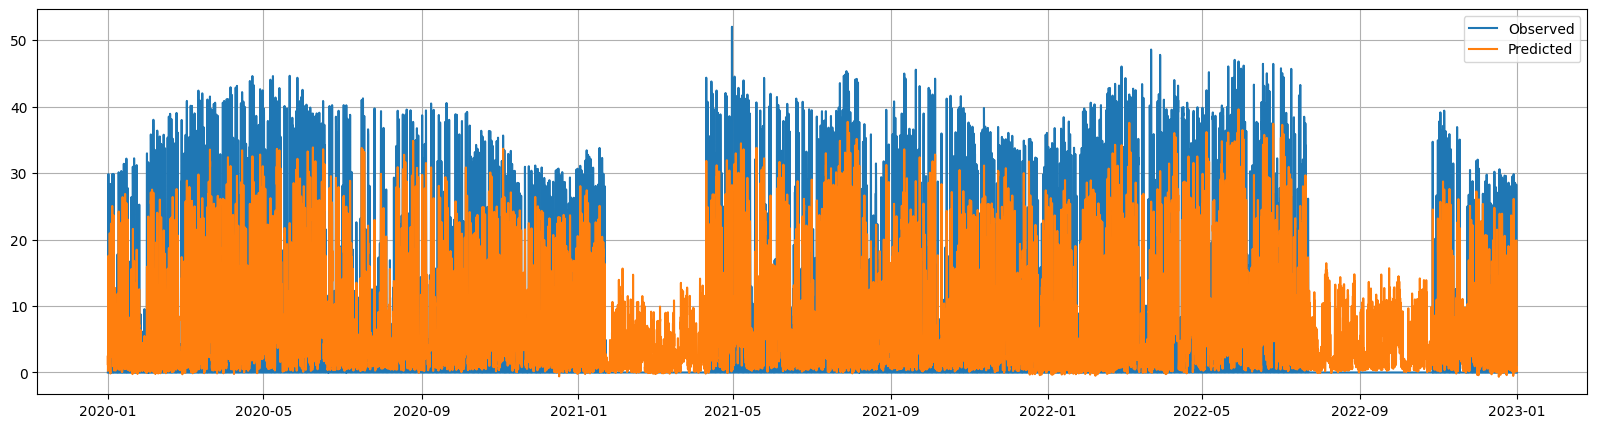

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
MSE :  0.03415402928107647
MAE :  0.13104290634158947
R2 :  0.21411082779876245


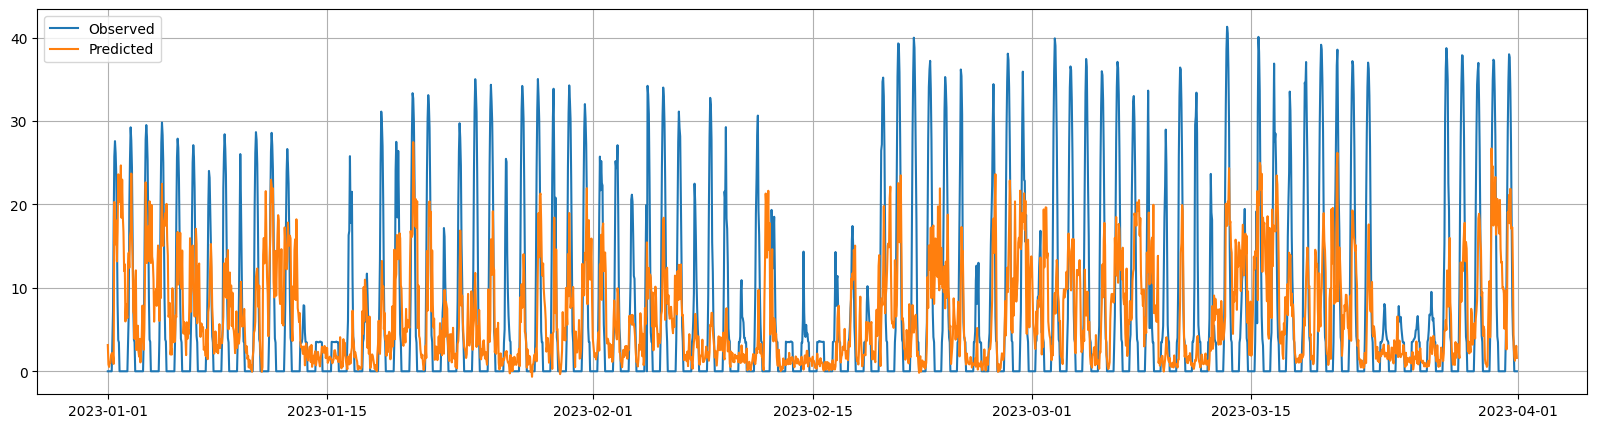

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 37 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_scgmq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.139 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
      temperature  windspeed  Precipitation  Humidity      PM10     PM2.5
0        0.327122   0.326316            0.0  0.417559  0.070707  0.070848
1        0.287785   0.115789            0.0  0.492505  0.069264  0.078978
2        0.310559   0.147368            0.0  0.449679  0.076479  0.089431
3        0.291925   0.147368            0.0  0.481799  0.078644  0.084785
4        0.289855   0.073684            0.0  0.503212  0.086580  0.096400
...           ...        ...            ...       ...       ...       ...
2155     0.552795   0.094737            0.0  0.760171  0.097403  0.062718
2156     0.536232   0.021053            0.0  0.770878  0.091631  0.070848
2157     0.511387   0.010526            0.0  0.802998  0.099567  0.070848
2158     0.492754   0.021053            0.0  0.824411  0.101732  0.077

H2OJobCancelled: ignored

In [34]:
# 입력 데이터
X = raw_data.drop(columns=['AC_출력_1', 'AC_출력_2'])

for target in ['AC_출력_1', 'AC_출력_2']:

    # 출력 데이터
    y = raw_data[[target]]

    # train, test 분리
    test_date = '2022-12-31 23:00:00'
    x_train = X.loc[X.index <= test_date, :]
    y_train = y.loc[y.index <= test_date, :]

    x_test = X.loc[X.index > test_date, :]
    y_test = y.loc[y.index > test_date, :]

    # 스케일러 적용
    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    # train 데이터만 가지고 scaler fitting
    scaler.fit(x_train)
    y_scaler.fit(y_train)

    # Train 데이터 스케일러 적용
    x_train_scaled_df = pd.DataFrame()
    y_train_scaled_df = pd.DataFrame()

    x_train_scaled = scaler.transform(x_train)
    y_train_scaled = y_scaler.transform(y_train)

    # 스케일러 적용 후 데이터 프레임 형식으로 변환
    x_train_scaled_df[x_train.columns] = x_train_scaled
    y_train_scaled_df[y_train.columns] = y_train_scaled

    # Test 데이터 스케일러 적용
    x_test_scaled_df = pd.DataFrame()
    y_test_scaled_df = pd.DataFrame()

    x_test_scaled = scaler.transform(x_test)
    y_test_scaled = y_scaler.transform(y_test)

    # 스케일러 적용 후 데이터프레임 형식으로 변환
    x_test_scaled_df[x_test.columns] = x_test_scaled
    y_test_scaled_df[y_test.columns] = y_test_scaled

    # H2O 라이브러리 초기화
    h2o.init()

    # train 데이터를 H2O 데이터프레임으로 변환
    h2o_train = h2o.H2OFrame(pd.concat([x_train_scaled_df, y_train_scaled_df], axis=1))
    # test 데이터를 H2O 데이터프레임으로 변환
    # 테스트 데이터를 H2O 데이터프레임으로 변환
    h2o_test = h2o.H2OFrame(pd.concat([x_test_scaled_df, y_test_scaled_df], axis=1))

    # H2O특성과 타겟 변수를 정의
    x = h2o_train.columns
    x.remove(target)
    y = target

    print( x_test_scaled_df)

    # AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
    aml = H2OAutoML(
      max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
      # max_models=30,             # 생성할 최대 모델 수
      stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
      stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
      stopping_rounds=3,         # 조기 종료를 위한 반복 횟수
      nfolds=5,                  # 교차 검증(fold)의 개수
      seed=42,                   # 랜덤 시드
      # exclude_algos = ["StackedEnsemble"],

      # include_algos=["StackedEnsemble","XGBoost", "GBM"],  # 사용할 알고리즘들의 리스트
      keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
      keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
      keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
      sort_metric='RMSE',        # 성능 측정 기준
      export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

    aml.train(x=x, y=target, training_frame=h2o_train) #모델 학습

    # AutoML 결과 확인 (모든 모델 출력)
    # Leaderboard 데이터를 Pandas DataFrame으로 변환
    leaderboard_df = aml.leaderboard.as_data_frame()

    # 모든 모델의 성능 순위를 변수로 저장
    for idx, row in leaderboard_df.iterrows():
      model_id = row['model_id']
      rank = idx + 1
      exec(f"model_rank_{rank} = h2o.get_model('{model_id}')")

    # 모든 모델의 성능 순위 출력
    print("\n<< 모든 모델의 성능 순위 >>")
    for idx, row in leaderboard_df.iterrows():
      model_id = row['model_id']
      rank = idx + 1
      print(f"Model: {model_id}, Rank: {rank}")

    best_model = model_rank_1

    # 훈련된 모델 저장
    my_local_model = h2o.download_model(best_model)

    # 모델 세부 정보 출력
    print("Best model is: ", best_model)
    print("parameters info is", best_model.params)

    # Train 데이터 평가
    y_pred = best_model.predict(h2o_train)
    y_pred = y_pred.as_data_frame()
    y_pred = np.array(y_pred).reshape(-1, 1)

    print('MSE : ', mean_squared_error(y_train_scaled, y_pred))
    print('MAE : ', mean_absolute_error(y_train_scaled, y_pred))
    print('R2 : ', r2_score(y_train_scaled, y_pred))

    # Train 데이터 예측 결과 딕셔너리 저장
    y_pred_ori = y_scaler.inverse_transform(y_pred)
    y_pred_ori = pd.DataFrame(data=y_pred_ori, index=y_train.index)

    y_pred_tr_dict[target] = y_pred_ori

     # Train 데이터 예측 결과 시각화
    plt.figure(figsize=(20, 5))

    idx=len(y_train)
    plt.plot(y_train.index[-idx:], y_scaler.inverse_transform(y_train_scaled)[-idx:], label='Observed')
    plt.plot(y_train.index[-idx:], y_scaler.inverse_transform(y_pred)[-idx:], label='Predicted')
    plt.legend()
    plt.grid()
    plt.show()

    # Test 데이터 평가
    y_pred = best_model.predict(h2o_test)
    y_pred = y_pred.as_data_frame()
    y_pred = np.array(y_pred).reshape(-1, 1)

    print('MSE : ', mean_squared_error(y_test_scaled, y_pred))
    print('MAE : ', mean_absolute_error(y_test_scaled, y_pred))
    print('R2 : ', r2_score(y_test_scaled, y_pred))

    # Test 데이터 예측 결과 딕셔너리 저장
    y_pred_ori = y_scaler.inverse_transform(y_pred)
    y_pred_ori = pd.DataFrame(data=y_pred_ori, index=y_test.index)

    # Test 데이터 예측결과를 딕셔너리에 저장
    y_pred_te_dict[target] = y_pred_ori

    # Test 데이터 시각화
    plt.figure(figsize=(20, 5))

    idx=len(y_test)
    plt.plot(y_test.index[-idx:], y_scaler.inverse_transform(y_test_scaled)[-idx:], label='Observed')
    plt.plot(y_test.index[-idx:], y_scaler.inverse_transform(y_pred)[-idx:], label='Predicted')
    plt.legend()
    plt.grid()
    plt.show()


# 5. 총 예측 발전량에 대한 NMAE(%) 구하기

In [ ]:
# NMAE 평가지표 정의 함수
def NMAE_FUNC (true, pred, S):

    # 판다스 데이터프레임 기준
    # true : 실제발전량
    # pred : 예측발전량
    # S : 발전용량(kW)

    true_values = true.loc[true.values > S * 0.1, :]
    pred_values = pred.loc[true_values.index, :]

    AE = sum(abs(true_values.values - pred_values.values))
    NAE = AE / S
    NMAE = 100 * (NAE / len(true_values))

    return NMAE[0]

In [ ]:
tr_list = []
te_list = []

for key in y_pred_tr_dict.keys():
    tr_list.append(y_pred_tr_dict[key])
    te_list.append(y_pred_te_dict[key])

pred_tr = pd.concat(tr_list, axis=1)
pred_te = pd.concat(te_list, axis=1)

pred_tr.columns = ['예측_발전량_1', '예측_발전량_2']
pred_te.columns = ['예측_발전량_1', '예측_발전량_2']
pred_tr['예측총발전량'] = pred_tr.sum(axis=1)
pred_te['예측총발전량'] = pred_te.sum(axis=1)

true_tr = raw_data[['AC_출력_1', 'AC_출력_2']].loc[raw_data.index <= test_date, :]
true_te = raw_data[['AC_출력_1', 'AC_출력_2']].loc[raw_data.index > test_date, :]

true_tr['총발전량'] = true_tr.sum(axis=1)
true_te['총발전량'] = true_te.sum(axis=1)

S_total = 100 # 총 설비용량 : 100kW

# Train 예측총발전량에 대한 NMAE(%)
tr_NMAE = NMAE_FUNC(true=true_tr[['총발전량']], pred=pred_tr[['예측총발전량']], S=S_total)
print('Train NMAE(%) :', tr_NMAE, '%')

# Test 예측총발전량에 대한 NMAE(%)
te_NMAE = NMAE_FUNC(true=true_te[['총발전량']], pred=pred_te[['예측총발전량']], S=S_total)
print('Test NMAE(%) :', te_NMAE, '%')

# 6. 예측 결과 저장

In [ ]:
# Train, Test 결과 저장
pred_tr.to_csv('Train 예측 결과.csv', encoding='utf-8-sig')
pred_te.to_csv('Test 예측 결과.csv', encoding='utf-8-sig')

# Train, Test NMAE(%) 결과 저장
pd.DataFrame([tr_NMAE, te_NMAE], index=['Train_NMAE(%)', 'Test_NMAE(%)']).T.to_csv('NMAE_결과.csv', index=False, encoding='utf-8-sig')